In [145]:
import os
import random

import pandas as pd

from PIL import Image

import numpy as np
np.random.seed(42)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

import seaborn as sn
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

In [2]:
# Check if CUDA is available for training
trainOnGpu = torch.cuda.is_available()
if trainOnGpu:
    print('CUDA is available. Training on GPU.')
else:
    print('CUDA is not available. Training on CPU.')

CUDA is not available. Training on CPU.


### Load the data
The metadata (e.g., labels) is stored in comma-separated values (csv) files. We read the files into pandas DataFrames.

In [3]:
dataDir='gtsrb' # Needs to be adjusted depending on where data is stored
dataTrainDir = os.path.join(dataDir, 'Train')
dataTestDir = os.path.join(dataDir, 'Test')

if not os.path.isdir(dataDir):
    print("Path '{}' does not exist.".format(dataDir))
    
dfMeta = pd.read_csv(os.path.join(dataDir, 'Meta.csv'))
dfTest = pd.read_csv(os.path.join(dataDir, 'Test.csv'))
dfTrain = pd.read_csv(os.path.join(dataDir, 'Train.csv'))

This is how the training DataFrame is structured. The ClassId parameter is the ground truth for classification. The position of the traffic signs in the images, meaning the Region of Interest (ROI), has already been marked. Therefore, we don't need to worry about localization and we will concentrate on classification here.

In [4]:
dfTrain

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png
...,...,...,...,...,...,...,...,...
39204,52,56,5,6,47,51,42,Train/42/00042_00007_00025.png
39205,56,58,5,5,51,53,42,Train/42/00042_00007_00026.png
39206,58,62,5,6,53,57,42,Train/42/00042_00007_00027.png
39207,63,69,5,7,58,63,42,Train/42/00042_00007_00028.png


### The GTSRB dataset

The images in the dataset are small color images of different sizes that fall into one of 43 classes. As seen below, the dataset has unbalanced class frequencies which can vary by more than one order of magnitude. We will account for this skew when training the CNN.

Number of classes:  43


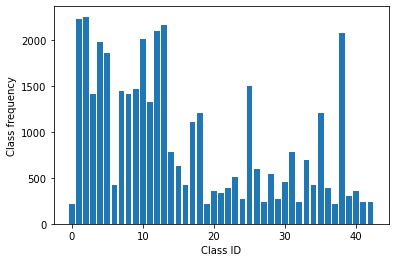

In [5]:
classFrequencies = dfTrain['ClassId'].value_counts()
classFrequencies.sort_index(inplace=True)

noClasses = len(classFrequencies)
print("Number of classes: ", noClasses)

plt.clf()
plt.bar(classFrequencies.index.tolist(), classFrequencies.tolist())
plt.xlabel("Class ID")
plt.ylabel("Class frequency")
plt.show()

### Prepare the dataset

The images in the dataset have differet sizes and we scale the input to a common dimension of 48x48 pixels after cropping the images to the region of interest.

Each image has 3 color channels (RGB). The RGB channels can be normalized in various ways, typically by transforming their mean to zero and their standard deviation to one. Often, the ImageNet means and standard deviations are used. However, the two datasets are different and we calculate the mean and standard deviation of the cropped and rescaled images in the training dataset for each color channel instead.

The main challenges are that the images are low resolution and have poor contrast. We improve the contrast/brightness by converting the RGB image to grayscale with one channel. We note that there are multiple other ways of enhancing the contrast, for example applying an Contrast Limited Adaptive Histogram Equalization (CLAHE) algorithmen or simply boost the brightness and contrast of each image. However, we find the grayscale approach as most promising.

We perform a simple data augmentation by randomly rotating our images by $\pm$10 degree. This adds additional rotational variety to the images and should make the predictions more robust with respect to rotational changes.

In [6]:
class LoadDataset(Dataset):
    """Class to load dataset using the CSV file"""

    def __init__(self, df, ddir, toTensor=True, train=True, normalize=None, toGray=True):
        """
        Args:
            df (data frame): Pandas DataFrame created from csv file
            ddir (string): Directory where GTSRB data is stored
            train (bool): If True, augmentation will be performed.
        """
        self.df = df
        self.ddir = ddir
        self.toTensor = toTensor
        self.train = train
        self.normalize = normalize
        self.toGray = toGray
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Load image using the Python Image Library (PIL)
        imgName = os.path.join(self.ddir, self.df.loc[idx, 'Path'])
        img = Image.open(imgName)
        
        # Crop image to the region of interest
        x1, y1, x2, y2 = self.df.loc[idx, ['Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2']]
        img = img.crop((x1, y1, x2, y2))
        
        # Apply transform
        img = self.transform(img)
        truth = self.df.loc[idx, 'ClassId']  

        return img, truth
    
    def transform(self, img):
        # Common transformations for all datasets
        imgSize = (48, 48)
        trafo = transforms.Compose([transforms.Resize(imgSize),])
        img = trafo(img)
        
        if self.toTensor:
            totensor = transforms.ToTensor()
            img = totensor(img)
        
        if self.normalize:
            norm = transforms.Normalize(*self.normalize)
            img = norm(img)
        
        if self.train:
            rotate = transforms.RandomRotation(10) # randomly rotate
            img = rotate(img)
            
        if self.toGray:
            gray = transforms.Grayscale(num_output_channels=1)
            img = gray(img)
        
        return img

In [7]:
# Compute mean and standard deviation for each channel in the training dataset
dataTemp = LoadDataset(dfTrain, dataDir, train=False, normalize=None, toGray=False)
if os.path.isfile('rgb_train_mean.npy') and os.path.isfile('rgb_train_std.npy'):
    rgbMean = np.load('rgb_train_mean.npy')
    rgbStd = np.load('rgb_train_std.npy')
else:
    imgChannels = 3
    rgbMean, rgbStd = [], []
    for channel in range(imgChannels):
        concat = torch.cat([dataTemp[i][0][channel] for i in range(len(dataTemp))])
        rgbMean.append(torch.mean(concat).item())
        rgbStd.append(torch.std(concat).item())

    rgbMean, rgbStd = np.round_(rgbMean,4), np.round_(rgbStd,4)
    # Save computed values
    np.save('rgb_train_mean.npy', rgbMean)
    np.save('rgb_train_std.npy', rgbStd)

print('Mean of RGB channels: \t\t\t{} \nStandard deviation of RGB channels: \t{}'.format(rgbMean, rgbStd))

Mean of RGB channels: 			[0.3589 0.3178 0.3358] 
Standard deviation of RGB channels: 	[0.2721 0.2555 0.2653]


In [8]:
# Temporary transformations for comparisson
dataTemp = LoadDataset(dfTrain, dataDir, toTensor=False, train=False, normalize=None, toGray=False)
dataTempN = LoadDataset(dfTrain, dataDir, train=False, normalize=[rgbMean, rgbStd]) 

Visualize example 8044


<Figure size 432x288 with 0 Axes>

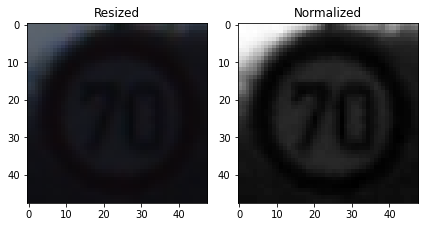

In [16]:
# Visualize a random image and its normalized version from the training set
idx = random.choice(range(len(dfTrain))) # 509 / 26076 / 937
print('Visualize example {}'.format(idx))

img, _ = dataTemp[idx]
imgN, _ = dataTempN[idx]

plt.clf()
fig, ax = plt.subplots(1,2)
ax[0].set_title('Resized')
ax[0].imshow(img);
ax[1].set_title('Normalized')
ax[1].imshow(np.transpose(imgN, (1, 2, 0))[:,:,0], cmap=plt.cm.gray);
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

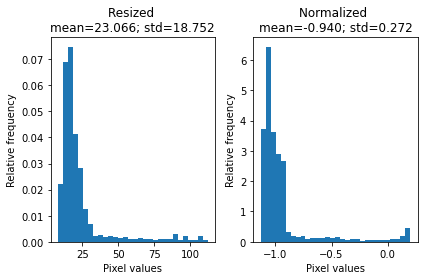

In [17]:
plt.clf()
fig, ax = plt.subplots(1,2)
ax[0].set_title('Resized \nmean={:.3f}; std={:.3f}'.format(np.mean(np.array(img).ravel()), np.std(np.array(img).ravel())))
ax[0].hist(np.array(img).ravel(), bins=30, density=True);
ax[1].set_title('Normalized \nmean={:.3f}; std={:.3f}'.format(np.mean(np.array(imgN).ravel()), np.std(np.array(imgN).ravel())))
ax[1].hist(np.array(imgN).ravel(), bins=30, density=True);

for a in (0,1):
    ax[a].set_xlabel("Pixel values")
    ax[a].set_ylabel("Relative frequency")

plt.tight_layout()

### Split dataset into training and validation

In [11]:
dataTrain = LoadDataset(dfTrain, dataDir, train=True, normalize=[rgbMean, rgbStd]) 

validSize = 0.2 # Percentage to use as validation

numTrain = len(dataTrain)
indices = list(range(numTrain))
np.random.shuffle(indices)
split = int(np.floor(validSize * numTrain))
idxTrain, idxValid = indices[split:], indices[:split]

# Define the samplers for training and validation
samplerTrain = SubsetRandomSampler(idxTrain)
samplerValid = SubsetRandomSampler(idxValid)

In [12]:
# Define number of subprocesses for data loading
numWorkers = 0

# Define how many samples per batch to load
batchSize = 32

# Create data loaders
loaderTrain = DataLoader(dataTrain, batch_size=batchSize, sampler=samplerTrain,  num_workers=numWorkers)
loaderValid = DataLoader(dataTrain, batch_size=batchSize, sampler=samplerValid,  num_workers=numWorkers)

### Visualize the training data

In [18]:
# Helper function to reverse normalization, convert tensor and display the image
def imshow(img):
    img = img * rgbStd[:, None, None] + rgbMean[:, None, None]
    # Scale image to ignore expected imshow warning:
    # Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
    img = (img.numpy() * 255).astype(np.uint8)
    plt.imshow(np.transpose(img, (1, 2, 0))[:,:,0], cmap=plt.cm.gray)
    
# Function to display a batch of the dataset 
def showBatch(dataset):
    plt.clf()
    plt.figure(figsize=(15,15))

    for i in range(1,11):
        plt.subplot(5,5,i)
        img, truth = dataset[random.choice(range(len(dataset)))]
        imshow(img)
        plt.title(truth)
        plt.axis('off')

<Figure size 432x288 with 0 Axes>

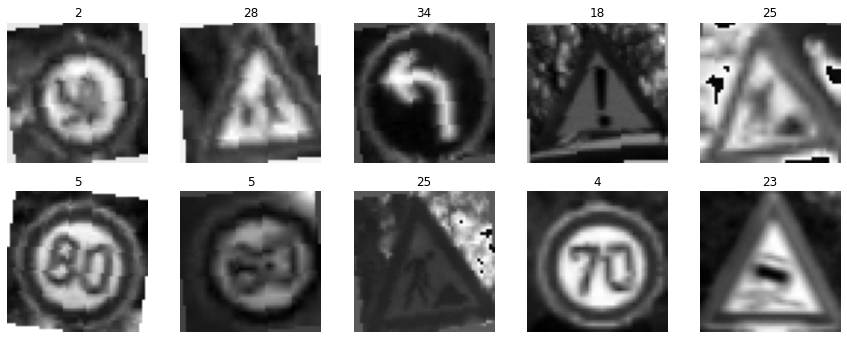

In [20]:
showBatch(dataTrain)

### Prepare the test dataset

In [21]:
dfTest

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png
...,...,...,...,...,...,...,...,...
12625,42,41,5,6,37,36,12,Test/12625.png
12626,50,51,6,5,45,46,33,Test/12626.png
12627,29,29,6,6,24,24,6,Test/12627.png
12628,48,49,5,6,43,44,7,Test/12628.png


In [22]:
dataTest = LoadDataset(dfTest, dataDir, train=False, normalize=[rgbMean, rgbStd]) 
loaderTest = DataLoader(dataTest, batch_size=batchSize,  num_workers=numWorkers)

### Define the CNN architecture
We use 3 convolutional layers, which each resemble a stack of filtered images. The maxpooling layers reduce the dimensions of an input by keeping only the most active pixels. Finally, linear and dopout layers are used to reduce overfitting and produce the 43 dimentional output. We use Rectified Linear Unit (ReLU) activation functions.

In [23]:
class Tsc(nn.Module):
    def __init__(self):
        super(Tsc, self).__init__()
        # convolutional layers
        self.conv1 = nn.Conv2d(1, 100, 7, padding=1)
        self.conv2 = nn.Conv2d(100, 150, 4, padding=1)
        self.conv3 = nn.Conv2d(150, 250, 4, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # fully connected layers
        self.fc1 = nn.Linear(250*4*4, 300)
        self.fc2 = nn.Linear(300, 43)
        # dropout layer
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(-1, 250*4*4)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x

# Create a complete CNN
model = Tsc()
print(model)

# Move to GPU if CUDA is available
if trainOnGpu:
    model.cuda()

Tsc(
  (conv1): Conv2d(1, 100, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(100, 150, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(150, 250, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4000, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=43, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


### Specify loss function and optimizer
As mentioned above, the class frequencies are unbalanced. We account for this by adding a weight for each class to the Cross-Entropy loss function. We choose the Adam algorithm with weight decay (AdamW) for optimization (see https://arxiv.org/abs/1711.05101).

In [24]:
# Weight the classes according to class frequencies
classWeights = torch.tensor(classFrequencies.tolist(), dtype=torch.float32)
classWeights /= classWeights.sum()
classWeights = 1.0 / classWeights
classWeights /= classWeights.sum()

criterion = nn.CrossEntropyLoss(weight=classWeights)
optimizer = optim.AdamW(model.parameters(), lr=0.001)

### Train the network

In [25]:
# Function to compute the loss and accuracies (total and individual classes)
def compNetPars(model, loader, noClasses, trainOnGpu):
    """
    noClasses (int): Number of classes
    strFlag (bool): If True, return string with detailed accuracies for each class
    """
    lossSet = 0.
    classCorrect = list(0. for i in range(noClasses))
    classTotal = list(0. for i in range(noClasses))
    
    # Iterate over data
    for idxBatch, (data, target) in enumerate(loader):
        # Move to GPU if available
        if trainOnGpu:
            data, target = data.cuda(), target.cuda()
        
        if model.training:
            # Clear gradients of optimized variables
            optimizer.zero_grad()
        
        # Forward pass: pass input to model and compute predicted output
        output = model(data)
        # Calculate loss of the batch
        loss = criterion(output, target)
        
        if model.training:
            # Backward pass: given the model parameters compute the gradients of the loss
            loss.backward()
            # Optimization step
            optimizer.step()
        
        # Add to set loss
        lossSet += loss.item()*data.size(0)
        
        # Convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # Compare predictions to true label
        correctTensor = pred.eq(target.data.view_as(pred))
        correct = correctTensor.numpy() if not trainOnGpu else correctTensor.cpu().numpy()
        
        # For each object class calculate set accuracy
        for i in range(len(target)):
            label = target.data[i]
            classCorrect[label] += correct[i].item()
            classTotal[label] += 1
    
    # Average loss
    lossSet = lossSet/len(loader.sampler)
    
    # Overall Accuracy
    totAcc = 100. * np.sum(classCorrect) / np.sum(classTotal)
                        
    return classCorrect, classTotal, lossSet, totAcc      

In [34]:
# Specify the number of epochs to train the model
nEpochs = 16

# To track validation loss changes
lossValidMin = np.Inf

# To track loss and accuracy for each epoch
lossAll, accAll = [], []

for epoch in range(1, nEpochs+1):
    # Model training
    model.train()
    ccTrain, ctTrain, lossTrain, accTrain = compNetPars(model, loaderTrain, noClasses, trainOnGpu)
    
    # Model validation
    model.eval()
    ccValid, ctValid, lossValid, accValid = compNetPars(model, loaderValid, noClasses, trainOnGpu)
    
    # Save the model if validation loss decreases
    if lossValid < lossValidMin:
        torch.save(model.state_dict(), 'model_tsc.pt')
        lossValidMin = lossValid
    
    # Model test
    ccTest, ctTest, lossTest, accTest = compNetPars(model, loaderTest, noClasses, trainOnGpu)
    
    lossAll.append([lossTrain, lossValid, lossTest])
    accAll.append([accTrain, accValid, accTest])
    
    if epoch == 1:
        print('Epoch \tTraining \t\tValidation \t\tTest \n')
        print(' \tLoss / Accuracy \tLoss / Accuracy \tLoss / Accuracy \n')
              
    print('{} \t{:.4f} / {:.2f}% \t{:.4f} / {:.2f}% \t{:.4f} / {:.2f}%'.format(
        epoch, lossTrain, accTrain, lossValid, accValid, lossTest, accTest))

# Save loss and accuracy history
np.save('history_loss.npy', lossAll)
np.save('history_accuracy.npy', accAll)     

Epoch 	Training 		Validation 		Test 

 	Loss / Accuracy 	Loss / Accuracy 	Loss / Accuracy 

1 	0.8088 / 77.89% 	0.1080 / 96.77% 	0.2279 / 94.31%
2 	0.1254 / 96.23% 	0.0742 / 97.91% 	0.2649 / 95.71%
3 	0.0919 / 97.15% 	0.0685 / 97.13% 	0.2267 / 94.81%
4 	0.0657 / 97.82% 	0.0467 / 98.64% 	0.1772 / 96.40%
5 	0.0764 / 97.81% 	0.0533 / 98.67% 	0.3956 / 96.15%
6 	0.0557 / 98.24% 	0.0703 / 98.32% 	0.3025 / 95.15%
7 	0.0829 / 97.60% 	0.0587 / 98.24% 	0.4078 / 94.89%
8 	0.0523 / 98.34% 	0.0478 / 99.08% 	0.3668 / 96.82%
9 	0.0458 / 98.61% 	0.1161 / 98.37% 	0.3145 / 96.01%
10 	0.0627 / 98.21% 	0.0427 / 99.17% 	0.2484 / 97.13%
11 	0.0726 / 98.10% 	0.0650 / 98.41% 	0.4052 / 95.80%
12 	0.0419 / 98.74% 	0.0578 / 98.34% 	0.2541 / 96.34%
13 	0.0506 / 98.55% 	0.0668 / 99.21% 	0.4241 / 97.05%
14 	0.0416 / 98.83% 	0.0384 / 99.36% 	0.2455 / 97.21%
15 	0.0571 / 98.49% 	0.1075 / 97.36% 	0.6344 / 95.08%
16 	0.0637 / 98.53% 	0.0449 / 99.31% 	0.3189 / 97.36%


### Look at loss and accuracy history
Typically, the training and validation loss decreases over time and we save the model if the validation loss decreases compared to the previously stored epoch. On the other hand, an increace of the validation loss might indicate possible overfitting.

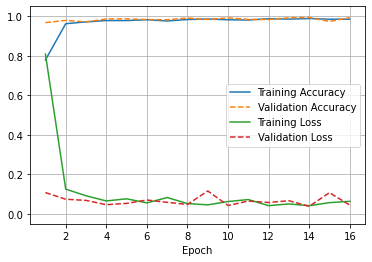

In [26]:
lossAll = np.load('history_loss.npy')
accAll = np.load('history_accuracy.npy')

plt.clf()
plt.xlabel("Epoch")

epochs = range(1, len(lossAll)+1)

plt.plot(epochs, accAll[:,0]/100., ls='-', label='Training Accuracy')
plt.plot(epochs, accAll[:,1]/100., ls='--', label='Validation Accuracy')

plt.plot(epochs, lossAll[:,0], ls='-', label='Training Loss')
plt.plot(epochs, lossAll[:,1], ls='--', label='Validation Loss')

plt.grid(True)
plt.ylim(-0.05,1.05)
plt.legend()
plt.show()

### Load model with lowest validation loss

In [27]:
model.load_state_dict(torch.load('model_tsc.pt'))
model.eval()
ccTest, ctTest, lossTest, accTest = compNetPars(model, loaderTest, noClasses, trainOnGpu)

In [28]:
for i in range(noClasses):
    if i == 0:
        print('Class \tClass frequency in training data \tAccuracy')
    if ctTest[i] > 0:
        print('{:.0f} \t{:.2f}% \t\t\t\t\t{:.2f}% ({:.0f}/{:.0f})'.format(
            i, 100 * classFrequencies[i] / classFrequencies.sum(),
            100 * ccTest[i] / ctTest[i], np.sum(ccTest[i]), np.sum(ctTest[i])))
    else:
        print('{:.0f} \tN/A (No training examples)'.format(i))
    
print('\nTest Accuracy (Overall): {:.2f}% ({:.0f}/{:.0f})'.format(
        accTest, np.sum(ccTest), np.sum(ctTest)))

Class 	Class frequency in training data 	Accuracy
0 	0.54% 					100.00% (60/60)
1 	5.66% 					99.44% (716/720)
2 	5.74% 					99.60% (747/750)
3 	3.60% 					96.67% (435/450)
4 	5.05% 					96.52% (637/660)
5 	4.74% 					98.73% (622/630)
6 	1.07% 					79.33% (119/150)
7 	3.67% 					97.78% (440/450)
8 	3.60% 					98.00% (441/450)
9 	3.75% 					100.00% (480/480)
10 	5.13% 					96.21% (635/660)
11 	3.37% 					100.00% (420/420)
12 	5.36% 					97.54% (673/690)
13 	5.51% 					99.58% (717/720)
14 	1.99% 					99.63% (269/270)
15 	1.61% 					99.52% (209/210)
16 	1.07% 					100.00% (150/150)
17 	2.83% 					99.44% (358/360)
18 	3.06% 					91.79% (358/390)
19 	0.54% 					66.67% (40/60)
20 	0.92% 					100.00% (90/90)
21 	0.84% 					93.33% (84/90)
22 	0.99% 					88.33% (106/120)
23 	1.30% 					100.00% (150/150)
24 	0.69% 					94.44% (85/90)
25 	3.83% 					96.88% (465/480)
26 	1.53% 					92.78% (167/180)
27 	0.61% 					98.33% (59/60)
28 	1.38% 					99.33% (149/150)
29 	0.69% 					100.00% (90/90)
30 	1.1

### Visualize test results
The provided regions of interest for a fraction of the test images is not accurate to crop properly at the edges of the signs. This might be a cause for misclassifcation. To mitigate this problem, one can apply a random cropping in the data augmentation step to improve image diversity or implement a localization algorithm.

In [60]:
def makePrediction(model, img, trainOnGpu):
    sm = nn.Softmax(dim=1)
    if trainOnGpu:
        img = img.cuda()
    
    img = img.unsqueeze(0) # Add extra dimention because the input are single images
    output = model(img)
    _, pred = torch.max(output, 1)    
    prob = sm(output)[0][pred]*100.
                        
    return [pred.item(), prob.item()]   

In [62]:
results = []
for idx in range(len(dataTest)):
    label = dataTest[idx][1]
    pred, prob = makePrediction(model, dataTest[idx][0], trainOnGpu)
    results.append([label, pred, prob])

results = np.array(results)

In [79]:
def showPredictions(dataset, results):
    plt.clf()
    plt.figure(figsize=(15,15))
    
    # Find indices where predictions match labels and where they do not
    posIndex = [index for index, (l,p,_) in enumerate(results) if l == p]
    negIndex = [index for index, (l,p,_) in enumerate(results) if l != p]
    # Plot 5 correctly classified examples and 5 incorrect classified.
    idxs = random.sample(posIndex, 5) + random.sample(negIndex, 5)

    for i, idx in zip(range(1,11), idxs):
        plt.subplot(5,5,i)
        img, _ = dataset[idx]
        imshow(img)
        label, pred, prob = results[idx]
        plt.title("Label: {:.0f}\nPrediction: {:.0f}({:.2f}%)".format(label, pred, prob),
                  color=("green" if pred==label else "red"))
        plt.axis('off')
    
    plt.tight_layout()

<Figure size 432x288 with 0 Axes>

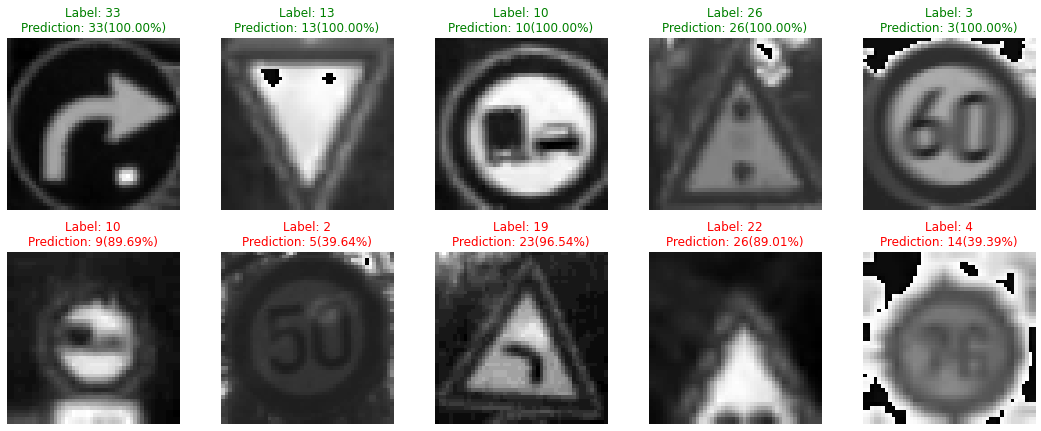

In [97]:
showPredictions(dataTest, results)

### Confusion matrix
The confusion matrix allows us to study whether the model is confusing sets of classes, for example if one class is commonly mislabeld as another. We are not displaying the zero entries in the confusion matrix for better readability.

In [171]:
dfResults = pd.DataFrame(results[:,:2], columns=['Label','Predicted'])
dfCm = pd.crosstab(dfResults['Label'], dfResults['Predicted'], rownames=['Label'], colnames=['Predicted'])

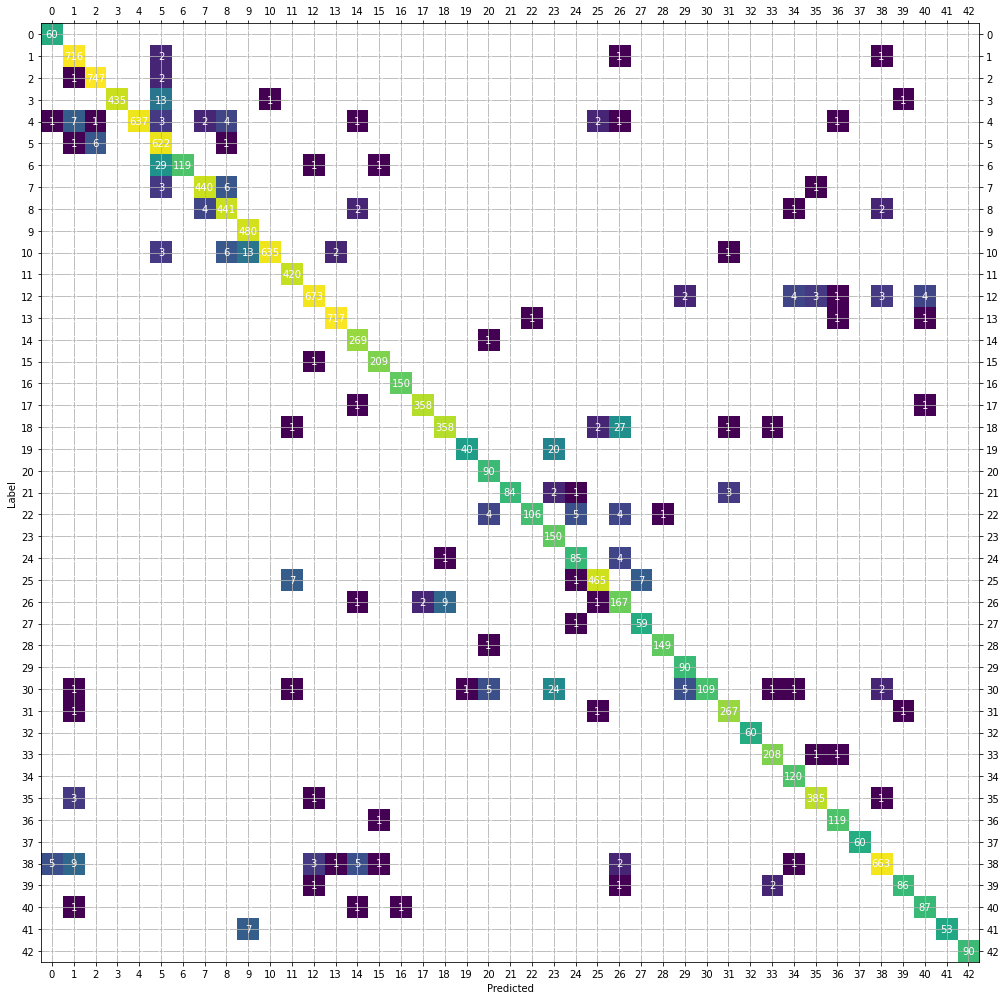

In [180]:
fig, ax = plt.subplots(figsize=(14, 14))
plt.grid()
im = ax.imshow(dfCm, norm=LogNorm())
# Set ticks
ax.set_xticks(range(noClasses))
ax.set_yticks(range(noClasses))
# Label ticks
ax.set_xticklabels(dfCm.index.astype(int))
ax.set_yticklabels(dfCm.index.astype(int))

ax.tick_params(labeltop=True, labelright=True)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')

ax.set_xlabel('Predicted')
ax.set_ylabel('Label')

# Loop over data dimensions and create text annotations.
for i in range(noClasses):
    for j in range(noClasses):
        text = ax.text(j, i, dfCm.loc[i, j],
                       ha="center", va="center", color="w")

fig.tight_layout()
plt.show()

### Discussion
The classification task works very well on the test dataset, with an average accuracy larger than 97%. However, there are a few classes that are not classified as accurate. For example the "Traffic signal" (26) and the "General caution" (18) signs, which look very similar in the pixelated dataset, causes some misclassification, skewed towards the less abundand class in the training dataset. The skewness might be improved by choosing another techniques over the weighted class approach to solve the imbalanced class problem. For example under-sampling (not preferred because we are not utilizing the total available data), data augmentation for minority classes, or synthetic minority over-sampling (SMOTE).

The first eight classes (the speed signs) show some confusion with one another. This might be improved by using a hierarchical CNN. This allows to first identify broader groups of classes, for example by their shape (round, triangular,...) and then classify additional features. An example would be to first classify the input as a speed sign and in the next step the actual speed limit. 